In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.anBiGLasso_cov import anBiGLasso
from Scripts.EiGLasso import EiGLasso_cov as EiGLasso
from Scripts.scBiGLasso import scBiGLasso_cov as scBiGLasso
from Scripts.utilities import binarize_matrix
from Scripts.antGLasso import antGLasso

In [4]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Mouse Embryonic Stem Cell Data
Data from paper "Computational analysis of cell-to-cell heterogeneity in single-cell RNA-sequencing data reveals hidden subpopulations of cells" by Buettner et al.
https://www.nature.com/articles/nbt.3102#accession-codes

Specifically, downloaded from here (the 'processed data'):
https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-2805

We use the same genes as used in the scBiGLasso paper - in the file `Nmythosis.txt`

In [5]:
# Read the data
mitosis_genes = pd.read_csv('../../Data/Nmythosis.txt')
G1_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G1_singlecells_counts.txt',
    sep='\t'
).dropna()
G2M_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G2M_singlecells_counts.txt',
    sep='\t'
).dropna()
S_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/S_singlecells_counts.txt',
    sep='\t'
).dropna()
G1_df = G1_df[G1_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
G2M_df = G2M_df[G2M_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
S_df = S_df[S_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]

In [6]:
# Get matrix of counts
# (transpose needed to mimic scBiGLasso)
G1_mat = G1_df.iloc[:, 4:].to_numpy()
G2M_mat = G2M_df.iloc[:, 4:].to_numpy()
S_mat = S_df.iloc[:, 4:].to_numpy()
counts = np.concatenate([S_mat, G1_mat, G2M_mat], axis=1).T[np.newaxis, ...]

In [7]:
counts

array([[[   0,    0,    0, ...,    0,    0,    0],
        [   7, 1954, 1254, ...,    1,    5,  558],
        [ 186, 1203, 2047, ...,   18,  180, 2335],
        ...,
        [ 195, 2553,  192, ...,   37,  119,  209],
        [   0, 1302,  216, ...,    3,    9, 1270],
        [ 153, 1190,  418, ...,   22,  153,  909]]])

In [8]:
# Transform to gaussian
T, S = nonparanormal_skeptic(counts)

## scBiGLasso

In [ ]:
# Takes too long to work
Psi, Theta = scBiGLasso(500, 10e-4, T, S, beta_1 = 0.2, beta_2 = 0.2)

In [ ]:

Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


## EiGLasso

In [246]:
# If we increase beta_2, it looks like the antGLasso results
Psi, Theta = EiGLasso(T, S, beta_1 = 0.4, beta_2 = 0.1)

<IPython.core.display.Javascript object>


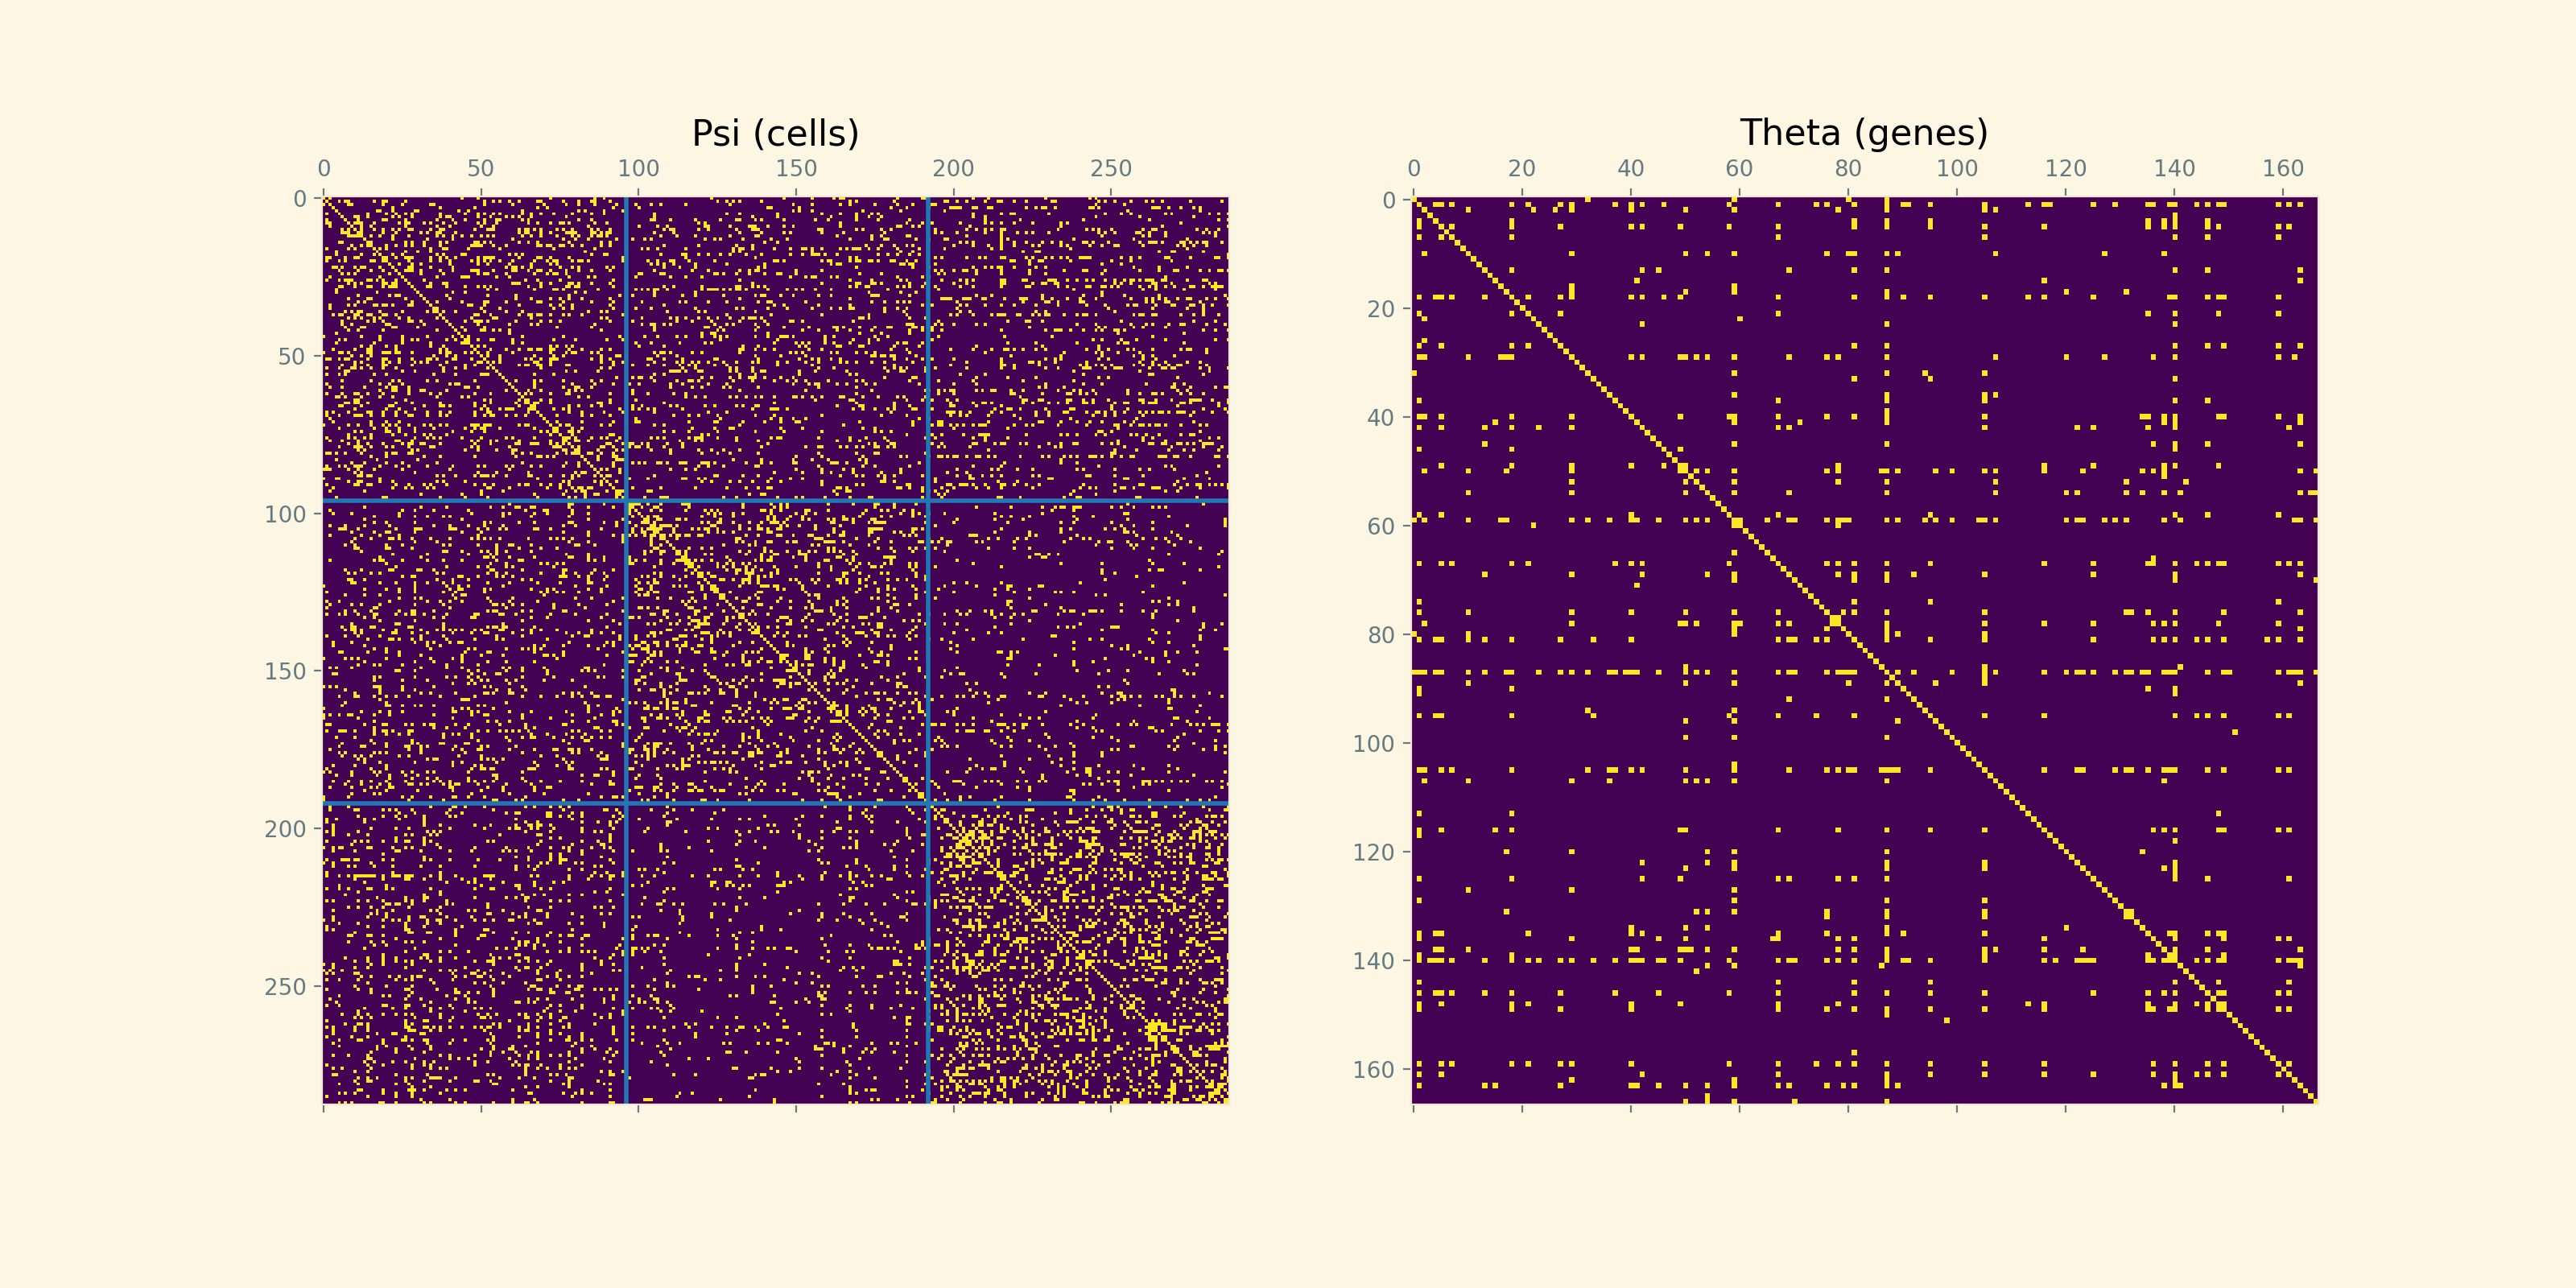

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


In [247]:

Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Mouse/EiGLasso Performance.png')
    fig.savefig('../../Plots/Final/EiGLasso Mouse Performance 1.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


In [28]:
# If we increase beta_2, it looks like the antGLasso results
Psi, Theta = EiGLasso(T, S, beta_1 = 0.4, beta_2 = 0.6)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


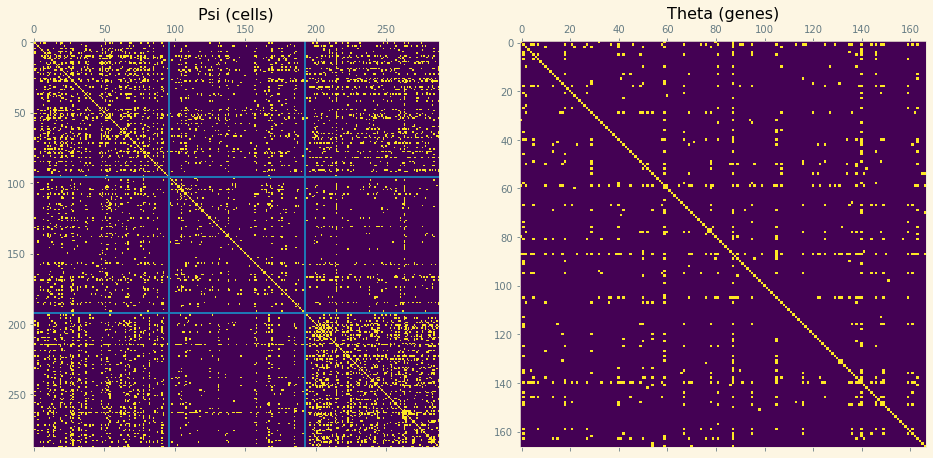

In [29]:

Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Mouse/EiGLasso Performance.png')
    fig.savefig('../../Plots/Final/EiGLasso Mouse Performance 2.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


# antGLasso

In [21]:
from scipy.stats import gamma
from scipy.stats import norm

library_means = counts.mean(axis=0, keepdims=True)
shape_param = counts.mean()
modified_counts = np.log(1+counts)

#To check we did modify reasonably: plt.hist(modified_counts[0, 2, :])

# Assuming the block diagonal structure is correct, exactly 1/3 of the elements should
# be selected.
Psi, Theta = antGLasso(modified_counts, sparsities=[1, 0.2], B_approx_iters=1000)

# TEST
#Psi = np.linalg.inv(Psi)
#from Scripts.antGLasso import shrink_sparsities
#Psi = shrink_sparsities([Psi], [0.2])[0]

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


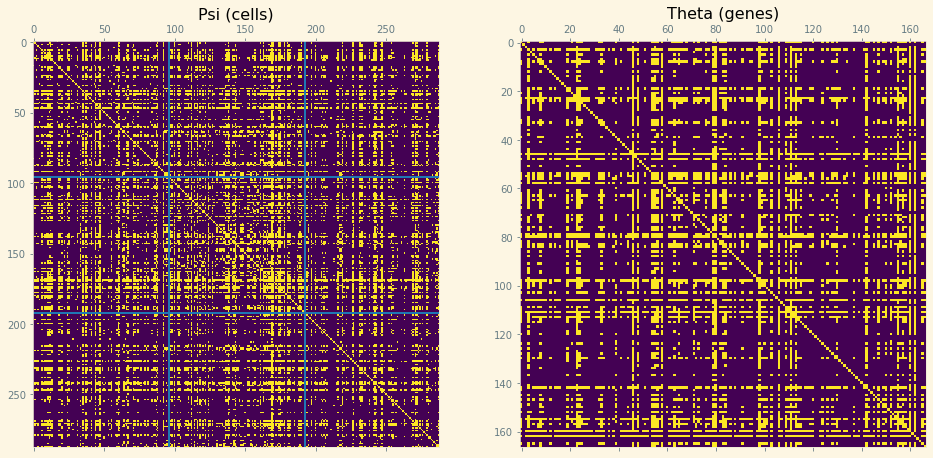

In [22]:

Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Final/antGLasso Mouse Performance Direct.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


In [10]:
from scipy.stats import gamma
from scipy.stats import norm

library_means = counts.mean(axis=0, keepdims=True)
shape_param = counts.mean()
modified_counts = np.log(1+counts)

#plt.hist(modified_counts[0, 2, :])

Psi, Theta = antGLasso(modified_counts, sparsities=[0.26, 0.2], B_approx_iters=1000)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


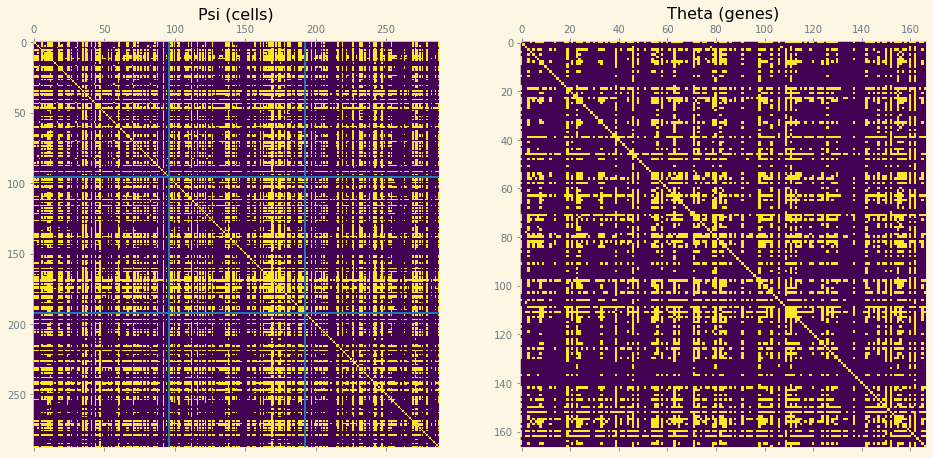

In [11]:

Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Mouse/EiGLasso Performance.png')
    fig.savefig('../../Plots/Final/antGLasso Mouse Performance Direct Fit.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


### Make gif of changing threshold

In [16]:
from scipy.stats import gamma
from scipy.stats import norm

library_means = counts.mean(axis=0, keepdims=True)
shape_param = counts.mean()
modified_counts = np.log(1+counts)

#plt.hist(modified_counts[0, 2, :])

Psi, Theta = antGLasso(modified_counts, sparsities=[1, 1], B_approx_iters=1000)

Psi_sorters = np.sort(np.abs(Psi.reshape(-1)))
Theta_sorters = np.sort(np.abs(Theta.reshape(-1)))
Psi_sorters.shape

(82944,)

<IPython.core.display.Javascript object>


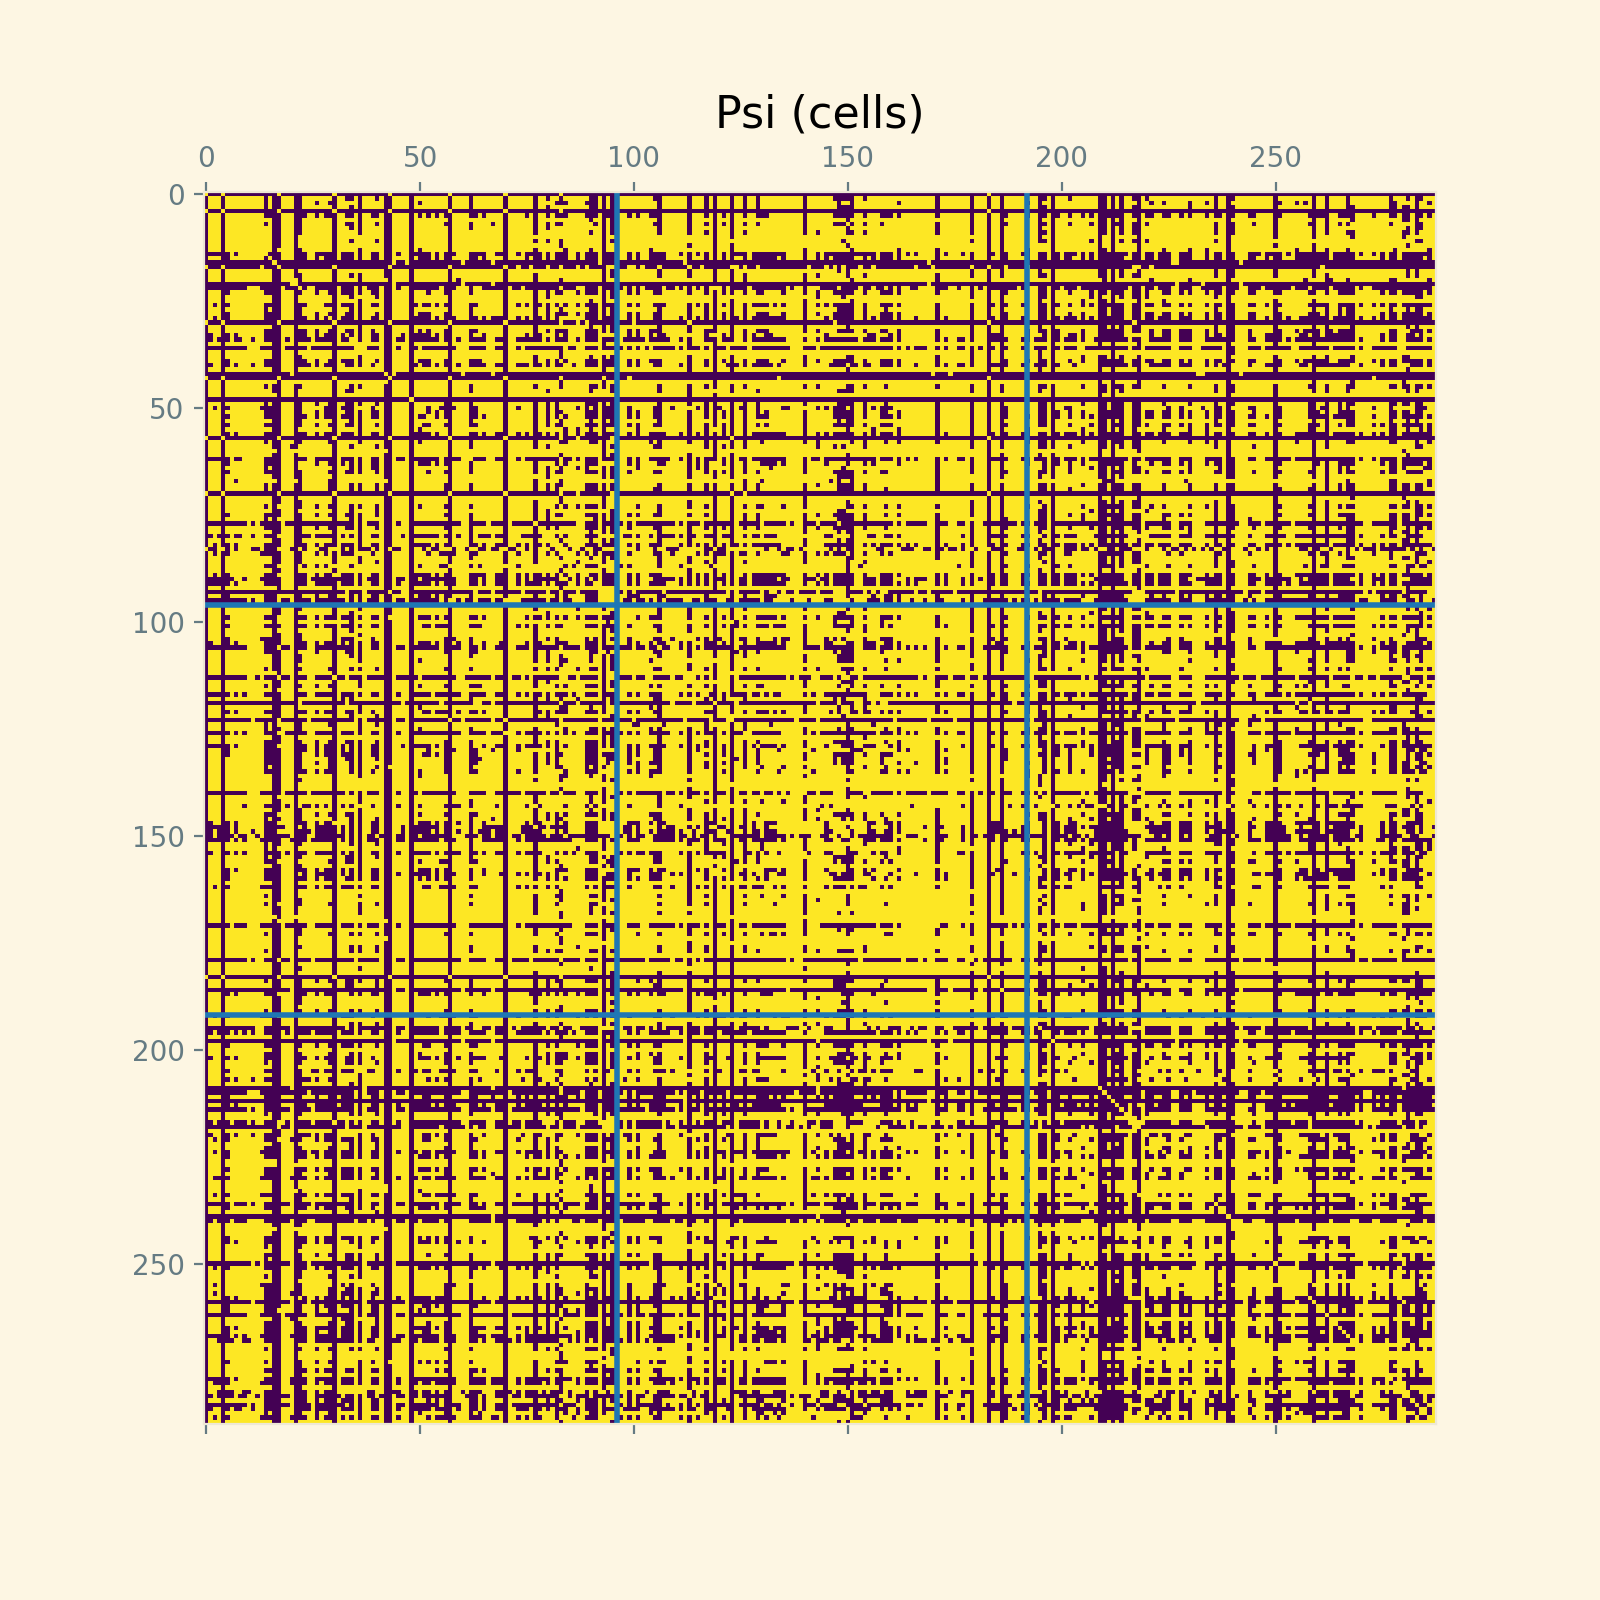

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


In [17]:
from  matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
# Don't bother with Theta since sizes are different, makes things complicated...
with plt.style.context('Solarize_Light2'):

    fig, ax1 = plt.subplots(ncols=1, figsize=(8, 8))

    ax1.grid(False)
    ax1.set_title('Psi (cells)')
    
    Psi_ = Psi.copy()
    Psi_[np.abs(Psi_) < Psi_sorters[10000]] = 0

    Psi_ = binarize_matrix(Psi_, mode='Nonzero')
    np.fill_diagonal(Psi_, 1)
    
    mat = ax1.matshow(Psi_)

    def update(idx):# 0 to 82943
        Psi_ = Psi.copy()
        Psi_[np.abs(Psi_) < Psi_sorters[idx*500]] = 0

        Psi_ = binarize_matrix(Psi_, mode='Nonzero')
        np.fill_diagonal(Psi_, 1)

        mat.set_data(Psi_)
        return [mat]

    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    anim = FuncAnimation(fig, update, frames=len(Psi_sorters) // 500, interval = 1, blit=True)
    anim.save("../../Plots/Final/antGLasso Mouse.gif", dpi=80, writer=PillowWriter(fps=25))

    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


# antGLasso with Heuristic

In [14]:
Psi, Theta = anBiGLasso(T, S, beta_1 = 0.012, beta_2 = 0.06, B_approx_iters=1000)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


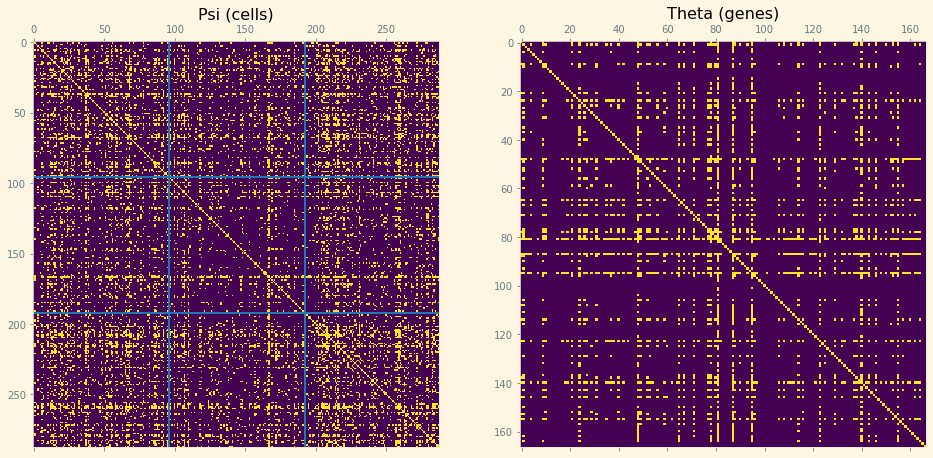

In [15]:

Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Mouse/EiGLasso Performance.png')
    fig.savefig('../../Plots/Final/antGLasso Mouse Performance Heuristic.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


## anBiGLasso

In [477]:
from scipy.stats import nbinom
mu = counts.mean(axis=2)
sigma = counts.std(axis=2)**2
p = 1 - mu / sigma
r = mu**2 / (sigma - mu)
nbinom.ppf(counts[0], p=p[0], n=r[0])

ValueError: operands could not be broadcast together with shapes (288,167) (288,) 

In [459]:
# Calculate precision matrices
#Psi, Theta = anBiGLasso(T, S, beta_1=1.1, beta_2=0.3, B_approx_iters=10)
from Scripts.anBiGLasso import anBiGLasso as anBiGLasso_raw
from scipy.stats import gamma, poisson
from scipy.stats import norm

"""
Good:
np.cbrt(counts+1),
beta_1=4000,
beta_2=100000,
B_approx_iters=1000
"""

#counts_aug = counts_ + np.zeros((50, 288, 167), dtype='int64')
#library_means_1 = counts_aug.mean(axis=1, keepdims=True)
#random_modification_1 = np.random.random(counts_aug.shape) * library_means_1 / 2
#counts_aug += random_modification_1

library_means = counts.mean(axis=0, keepdims=True)
print(library_means)
shape_param = counts.mean()
#print(gamma.cdf((counts+1) / (shape_param+1), 1))
#print(test := norm.ppf(gamma.cdf((counts+1) / (shape_param+1), 1)/1.1 + 0.01))
#print(np.isnan(test).any())
#print(np.isinf(test).any())
Psi, Theta = anBiGLasso_raw(
    norm.ppf(gamma.cdf((counts+1) / (library_means+shape_param), 1)/1.1+0.01),
    beta_1=370000,
    beta_2=5000000,
    B_approx_iters=1000
)
print(Psi)

[[[   0.    0.    0. ...    0.    0.    0.]
  [   7. 1954. 1254. ...    1.    5.  558.]
  [ 186. 1203. 2047. ...   18.  180. 2335.]
  ...
  [ 195. 2553.  192. ...   37.  119.  209.]
  [   0. 1302.  216. ...    3.    9. 1270.]
  [ 153. 1190.  418. ...   22.  153.  909.]]]
[[39577410.947        0.           0.    ...        0.           0.
         0.   ]
 [       0.    -8581405.046        0.    ...        0.           0.
         0.   ]
 [       0.           0.    -8892544.496 ...        0.           0.
         0.   ]
 ...
 [       0.           0.           0.    ... -8993918.791        0.
         0.   ]
 [       0.           0.           0.    ...        0.    -9121902.663
         0.   ]
 [       0.           0.           0.    ...        0.           0.
  -8601458.037]]


S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


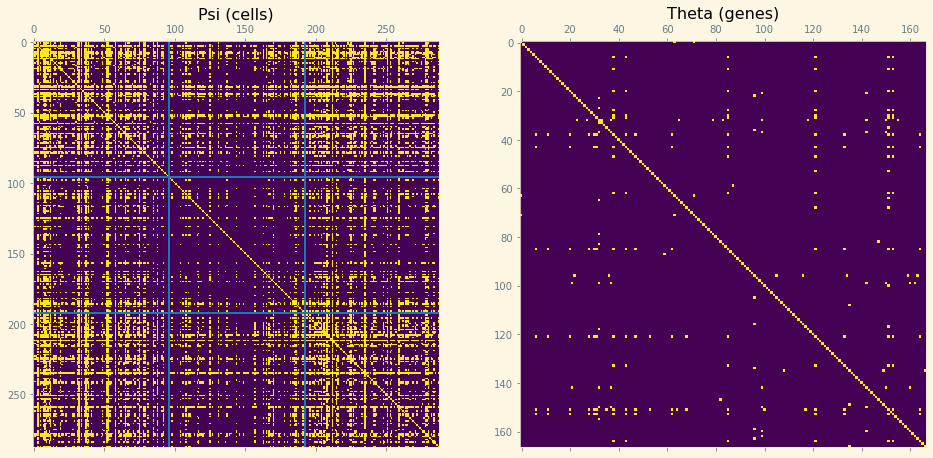

In [461]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Mouse/anBiGLasso Performance.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

# EiGLasso with anBiGLasso initialization
Note: this code requires modifying the EiGLasso code to accept custom
initialization parameters.

In [434]:
Psi, Theta = anBiGLasso(T, S, beta_1=0, beta_2=0)

print(Psi)
Psi, Theta = EiGLasso(
    T,
    S,
    beta_1=0.4,
    beta_2=0.4,
    Psi_init=Psi,
    Theta_init=Theta
)
print(Psi)

[[ 0.054  0.001 -0.002 ...  0.     0.     0.003]
 [ 0.001  0.113  0.001 ... -0.01   0.004 -0.001]
 [-0.002  0.001  0.081 ... -0.002  0.006  0.   ]
 ...
 [ 0.    -0.01  -0.002 ...  0.088 -0.006  0.007]
 [ 0.     0.004  0.006 ... -0.006  0.085 -0.011]
 [ 0.003 -0.001  0.    ...  0.007 -0.011  0.106]]
[[ 0.09   0.001 -0.002 ...  0.     0.     0.003]
 [ 0.001 -0.103  0.001 ... -0.023  0.004 -0.002]
 [-0.002  0.001  0.048 ... -0.002  0.006  0.   ]
 ...
 [ 0.    -0.023 -0.002 ...  0.097 -0.006  0.007]
 [ 0.     0.004  0.006 ... -0.006  0.048 -0.026]
 [ 0.003 -0.002  0.    ...  0.007 -0.026 -0.07 ]]


S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


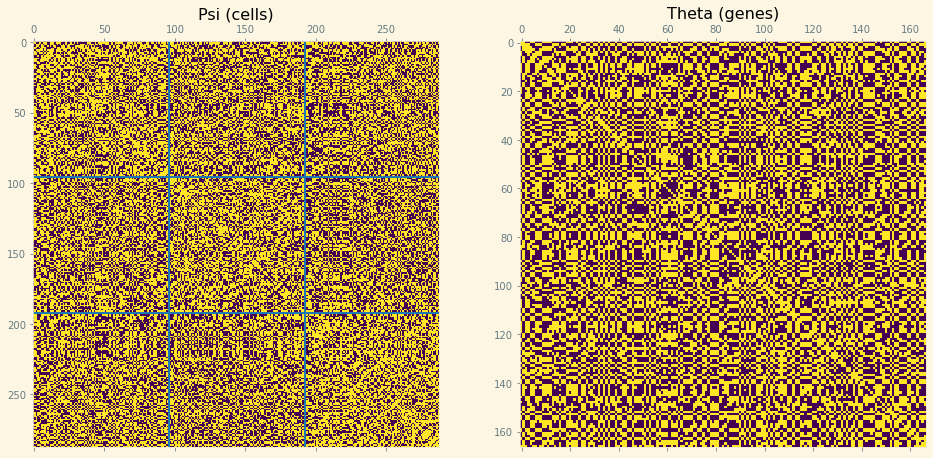

In [435]:
Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

# anBiGLasso with augmented data

In [26]:
counts_ = counts.copy()
counts_.shape

(1, 288, 167)

In [42]:
counts_aug = counts_ + np.zeros((50, 288, 167), dtype='int64')
counts_aug.shape

(50, 288, 167)

In [43]:
library_means_1 = counts_aug.mean(axis=1, keepdims=True)
random_modification_1 = np.random.random(counts_aug.shape) * library_means_1 / 2
library_means_2 = counts_aug.mean(axis=2, keepdims=True)
random_modification_2 = np.random.random(counts_aug.shape) * library_means_2 / 2

In [14]:
# Transform to gaussian
T, S = nonparanormal_skeptic(counts_aug + random_modification_1 + 0 * random_modification_2)

In [15]:
# Calculate precision matrices 
Psi, Theta = anBiGLasso(T, S, beta_1=0.017, beta_2=0.0005, B_approx_iters=10)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


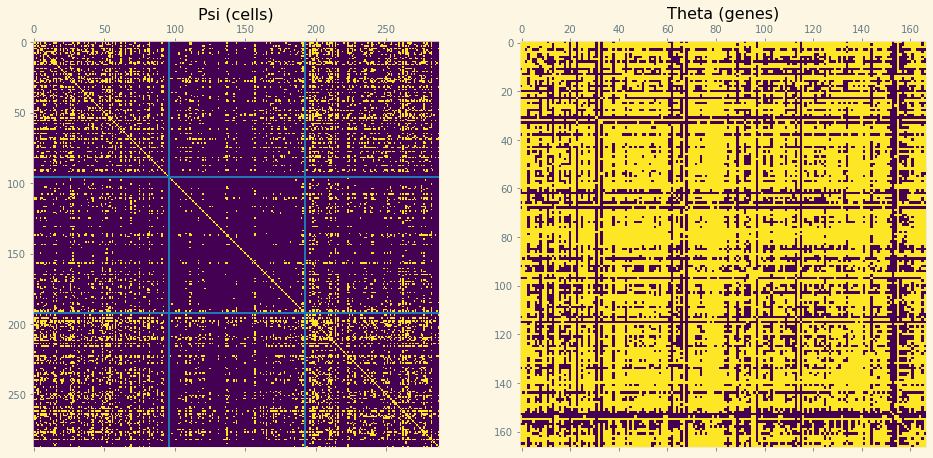

In [16]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Mouse/anBiGLasso Performance Augmented.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

# antGLasso

In [27]:
counts_aug = counts_ + np.zeros((50, 288, 167), dtype='int64')
library_means_1 = counts_aug.mean(axis=1, keepdims=True)
random_modification_1 = np.random.random(counts_aug.shape) * library_means_1 / 2
library_means_2 = counts_aug.mean(axis=2, keepdims=True)
random_modification_2 = np.random.random(counts_aug.shape) * library_means_2 / 2

In [28]:
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
Ss = nonparanormal_tensor_skeptic(counts_aug + random_modification_1)

In [30]:
from Scripts.antGLasso import antGLasso_heuristic
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[0.11, 0.1], B_approx_iters=1000)

<IPython.core.display.Javascript object>


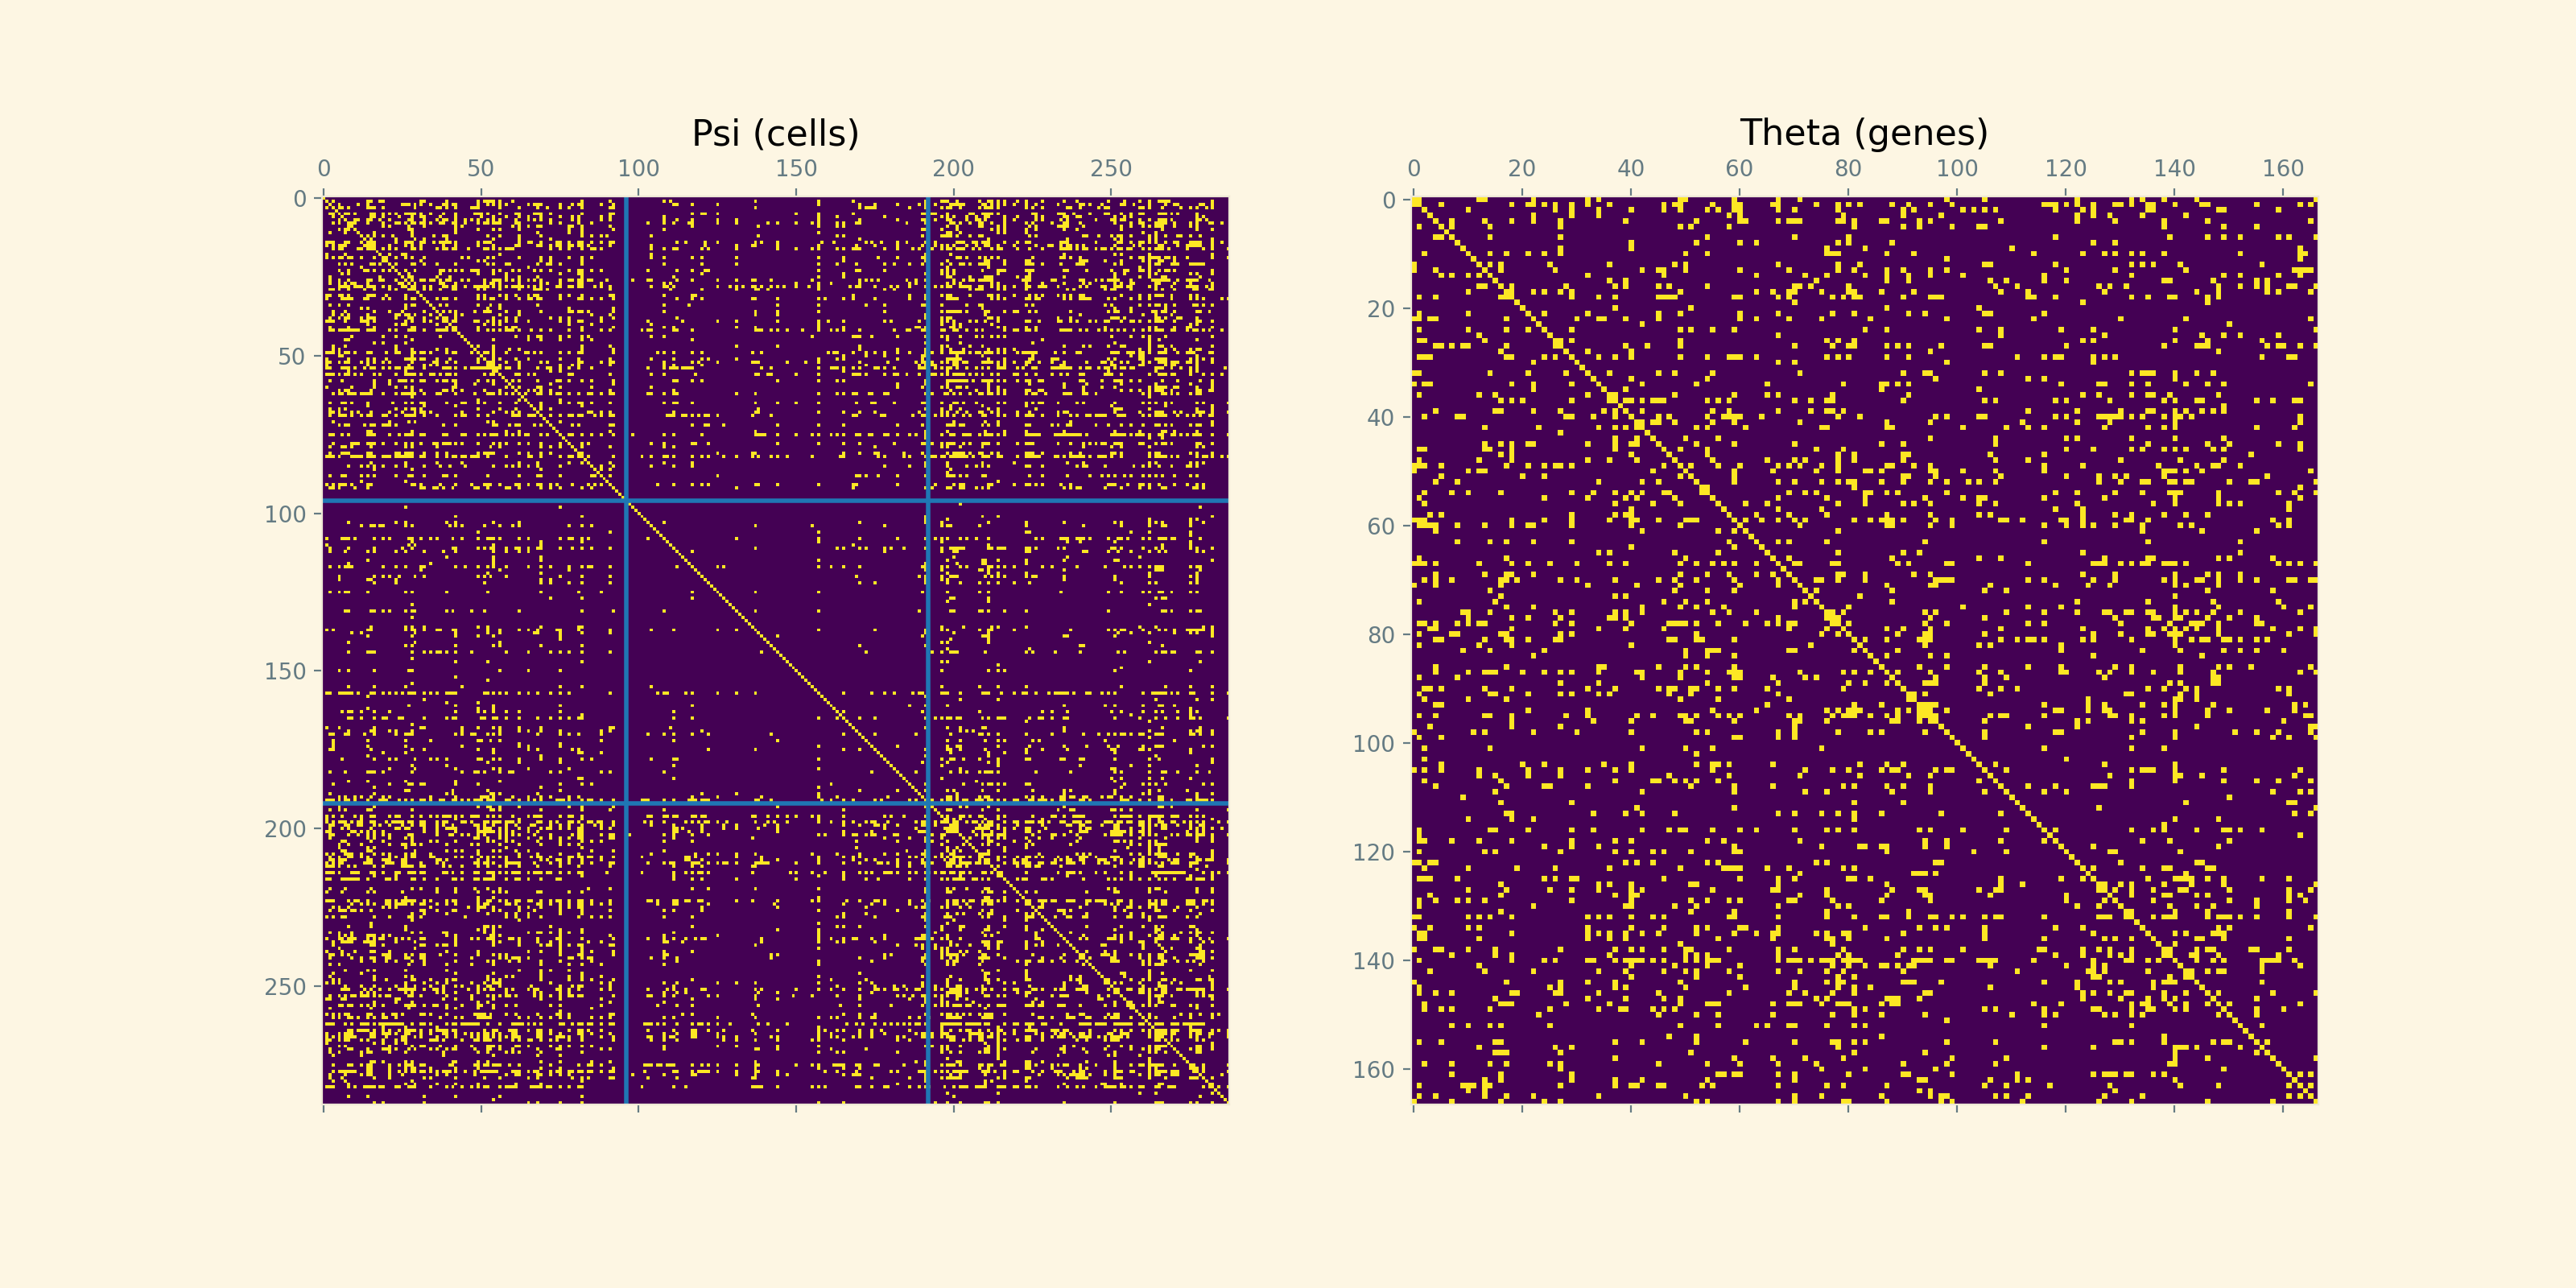

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


In [67]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Final/antGLasso Performance Augmented.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

In [31]:
Ss = nonparanormal_tensor_skeptic(counts)
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[0.11, 0.1], B_approx_iters=1000)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


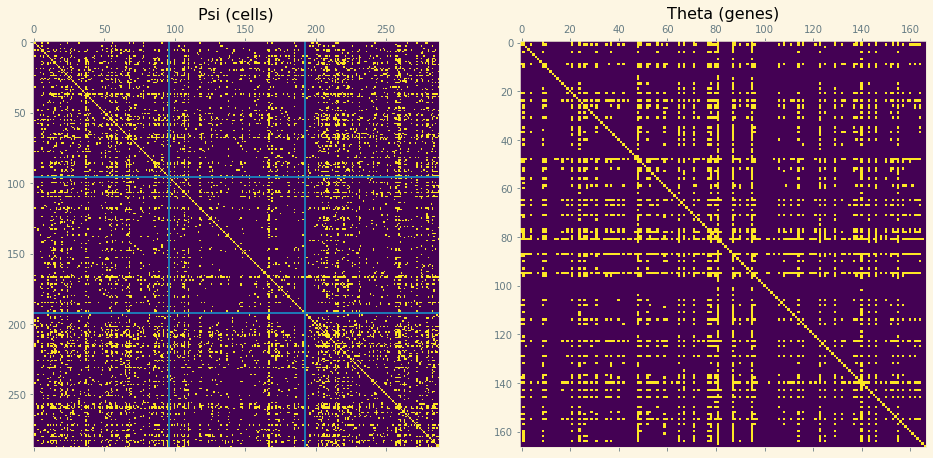

In [32]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    #fig.savefig('../../Plots/Final/antGLasso Performance Unaugmented.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

### What if we use covariance matrix?

In [51]:
from Scripts.anBiGLasso import calculate_empirical_covariances
Ss = calculate_empirical_covariances(counts)
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[1, 1], B_approx_iters=1000)
Psi, Theta = shrink_sparsities([np.linalg.inv(Psi), np.linalg.inv(Theta)], [0.17, 0.2])

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


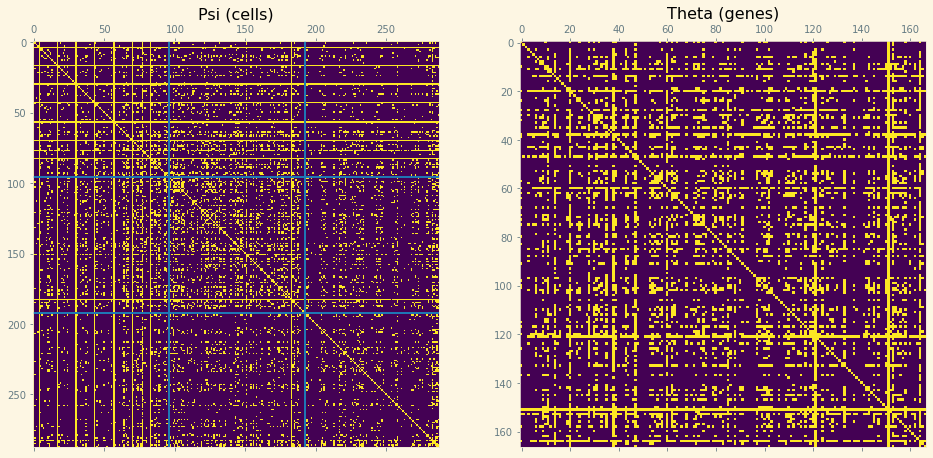

In [52]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Final/antGLasso Performance CovMat Direct.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

In [53]:
from Scripts.anBiGLasso import calculate_empirical_covariances
Ss = nonparanormal_tensor_skeptic(counts)
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[1, 1], B_approx_iters=1000)
Psi, Theta = shrink_sparsities([np.linalg.inv(Psi), np.linalg.inv(Theta)], [0.2, 0.2])

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


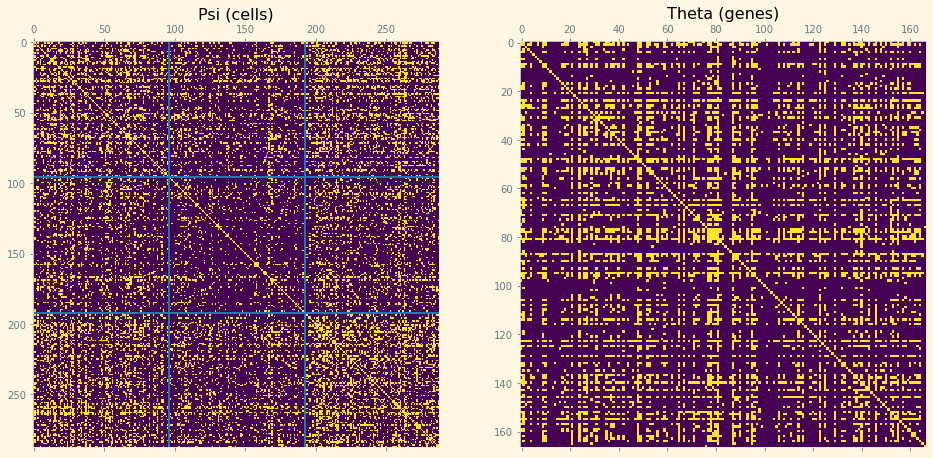

In [54]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Final/antGLasso Performance CovMat Nonparanormal.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

## Gif

In [55]:
Ss = nonparanormal_tensor_skeptic(counts_aug + random_modification_1)
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[1, 1], B_approx_iters=1000)
Psi_sorters = np.sort(np.abs(Psi.reshape(-1)))

<IPython.core.display.Javascript object>


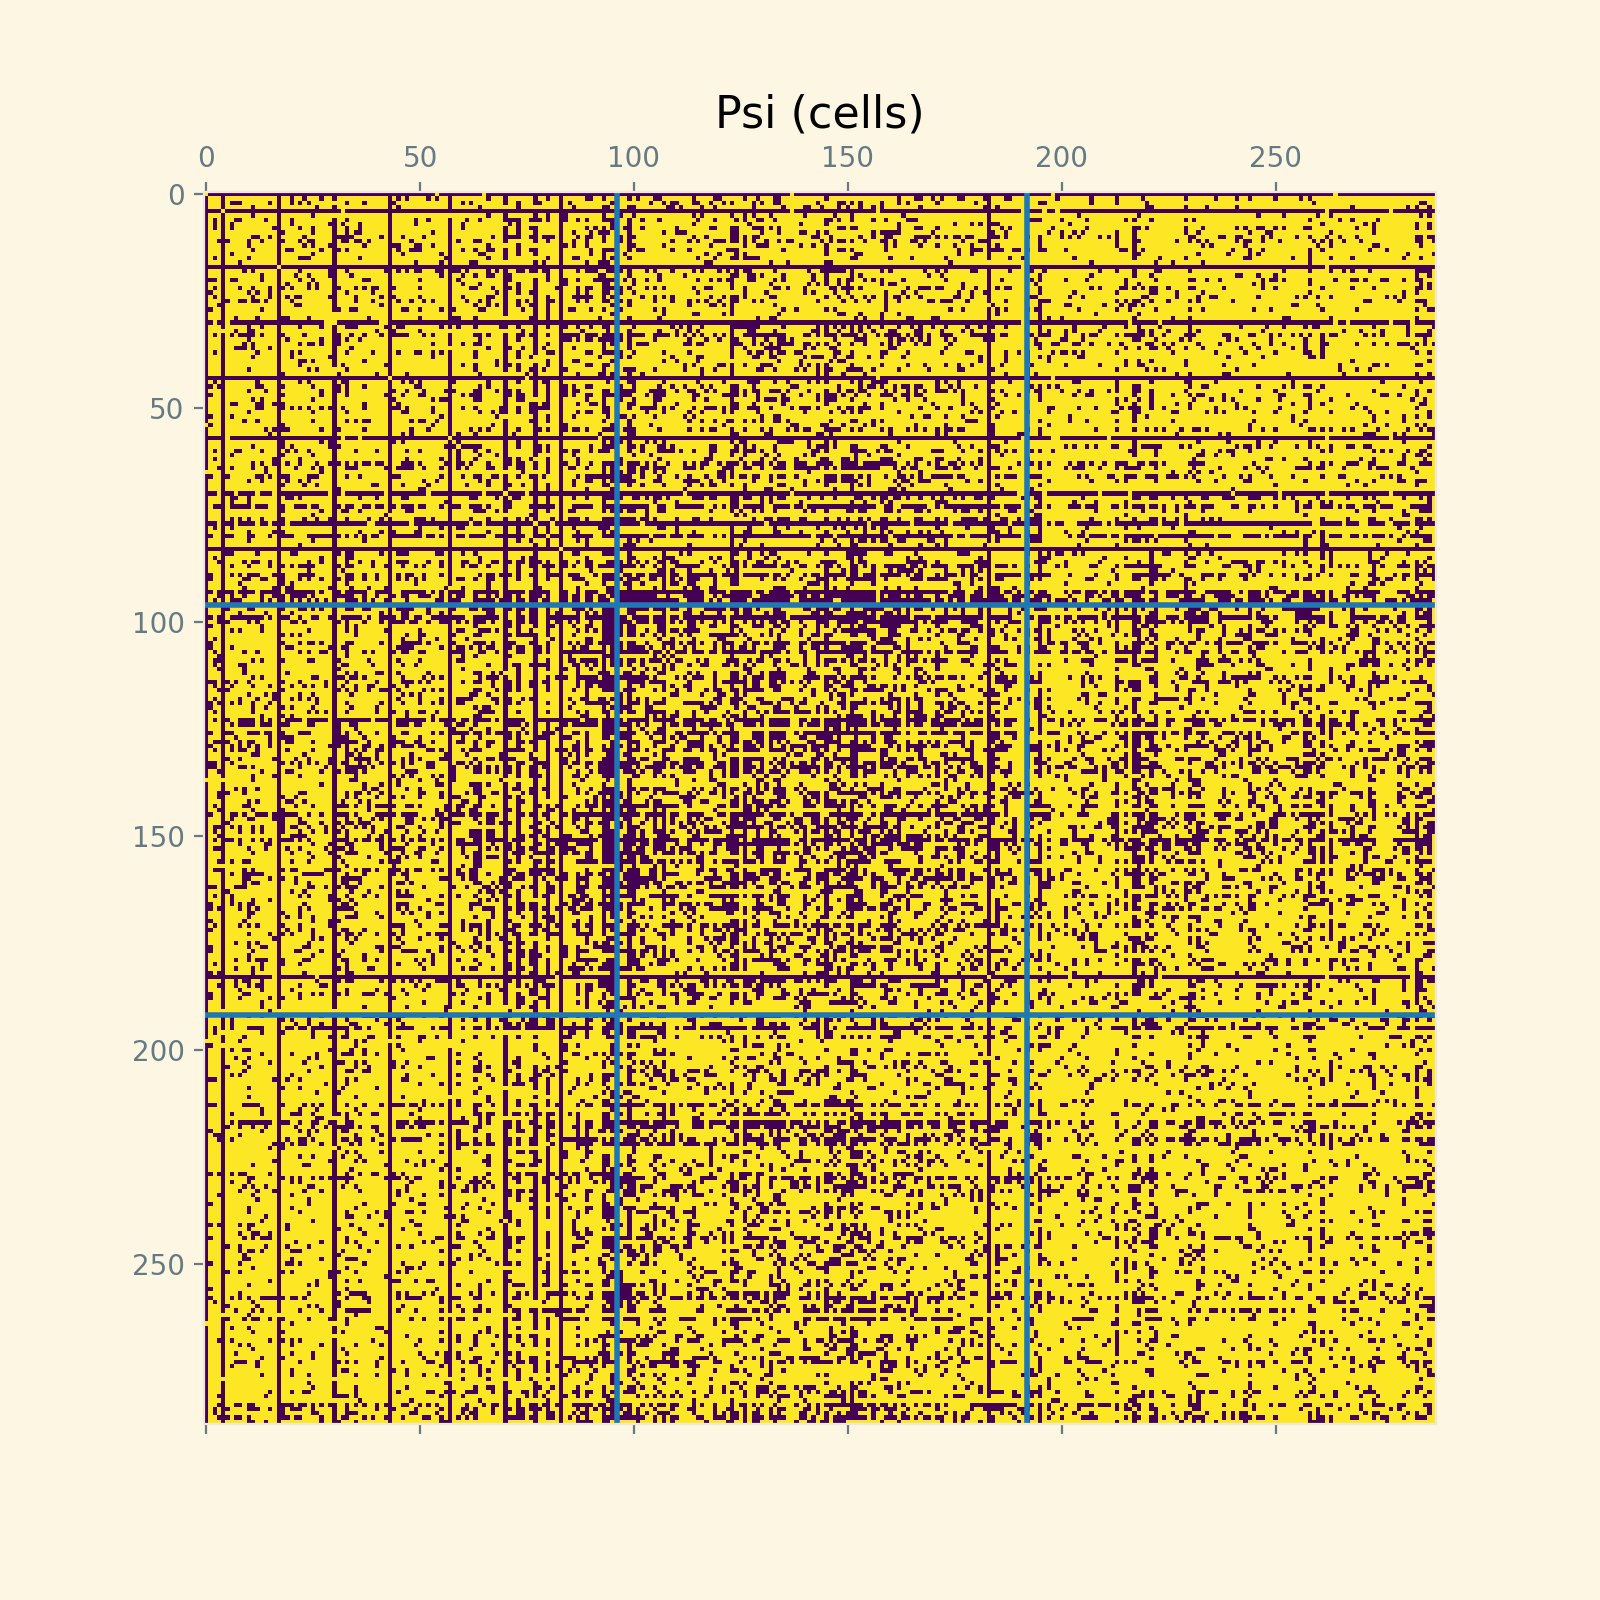

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


In [56]:
from  matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
# Don't bother with Theta
with plt.style.context('Solarize_Light2'):

    fig, ax1 = plt.subplots(ncols=1, figsize=(8, 8))

    ax1.grid(False)
    ax1.set_title('Psi (cells)')
    
    Psi_ = Psi.copy()
    Psi_[np.abs(Psi_) < Psi_sorters[10000]] = 0

    Psi_ = binarize_matrix(Psi_, mode='Nonzero')
    np.fill_diagonal(Psi_, 1)
    
    mat = ax1.matshow(Psi_)

    def update(idx):# 0 to 82943
        Psi_ = Psi.copy()
        Psi_[np.abs(Psi_) < Psi_sorters[idx*500]] = 0

        Psi_ = binarize_matrix(Psi_, mode='Nonzero')
        np.fill_diagonal(Psi_, 1)

        mat.set_data(Psi_)
        return [mat]

    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    anim = FuncAnimation(fig, update, frames=len(Psi_sorters) // 500, interval = 1, blit=True)
    anim.save("../../Plots/Final/antGLasso Mouse.gif", dpi=80, writer=PillowWriter(fps=25))

    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")
